In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from mpl_toolkits.mplot3d import Axes3D

## Linear Regression

Prepare train and test data.

In [3]:
data_original = np.loadtxt('stanford_dl_ex/ex1/housing.data')
data = np.insert(data_original, 0, 1, axis=1)
np.random.shuffle(data)
train_X = data[:400, :-1]
train_y = data[:400, -1]
test_X = data[400:, :-1]
test_y = data[400:, -1]

m, n = train_X.shape

Define functions for Linear Regression (using Gradient Descent).

In [4]:
def cost_function(theta, X, y): 
    squared_errors = (X.dot(theta) - y) ** 2
    J = 0.5 * squared_errors.sum()
    return J

def gradient(theta, X, y):
    errors = X.dot(theta) - y
    return errors.dot(X)

def train(X, y):
    return scipy.optimize.minimize(
        fun=cost_function,
        x0=np.random.rand(n),
        args=(X, y),
        method='bfgs',
        jac=gradient,
        options={'maxiter': 200, 'disp': False},
    ).x

## Learning Curve

Define the number of equally sized parts the training data should be split up into. This equals the number of models that will be created.

In [5]:
fractions = 20

In every iteration:
1. Add one fraction of the full train set to the current train set.
2. Train a model.
3. Compute and save its Root Mean Square Error for both the current train set and the test set.

In [6]:
rms_train = np.zeros(fractions)
rms_test = np.zeros(fractions)
for i, fraction in enumerate(np.linspace(m / fractions, m, fractions)):
    optimal_theta = train(train_X[:fraction], train_y[:fraction])
    rms_train[i] = np.sqrt(np.mean((train_X[:fraction].dot(optimal_theta) - train_y[:fraction]) ** 2))
    rms_test[i] = np.sqrt(np.mean((test_X.dot(optimal_theta) - test_y) ** 2))

Now we can plot the Learning Curve.

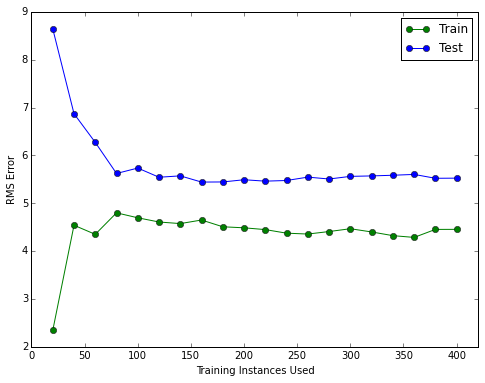

In [7]:
plt.figure(figsize=(8, 6))
plt.xlim(0, m + m / fractions)
plt.xlabel('Training Instances Used')
plt.ylabel('RMS Error')
plt.plot(np.linspace(m / fractions, m, fractions), rms_train, c='g', marker='o', label='Train')
plt.plot(np.linspace(m / fractions, m, fractions), rms_test, c='b', marker='o', label='Test')
plt.legend()

## 3D Plots

### Scatter Plots

The column with index 6 corresponds to the "Average Number of Rooms".<br>
The column with index 13 corresponds to the "% lower status of the population".<br>
See https://archive.ics.uci.edu/ml/datasets/Housing for more information.

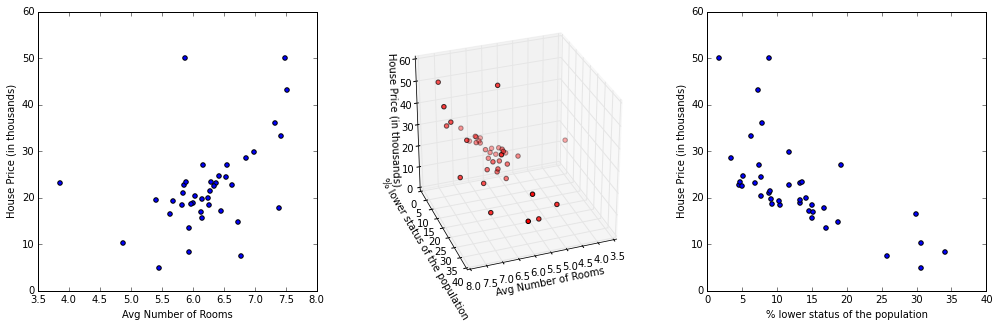

In [8]:
fig = plt.figure(figsize=(17, 5))

ax = fig.add_subplot(131)
ax.scatter(train_X[:40, 6], train_y[:40], c='b', marker='o')
ax.set_xlabel('Avg Number of Rooms')
ax.set_ylabel('House Price (in thousands)')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(train_X[:40, 6], train_X[:40, 13], train_y[:40], c='r', marker='o')
ax.set_xlabel('Avg Number of Rooms')
ax.set_ylabel('% lower status of the population')
ax.set_zlabel('House Price (in thousands)')
ax.view_init(30, 70)

ax = fig.add_subplot(133)
ax.scatter(train_X[:40, 13], train_y[:40], c='b', marker='o')
ax.set_xlabel('% lower status of the population')
ax.set_ylabel('House Price (in thousands)')

### Contour Plots

First, let's define a new training function which also returns the theta values of every optimization step.

In [9]:
def train_with_history(X, y):
    theta = np.random.rand(X.shape[1])
    history = [theta]
    optimal_theta = scipy.optimize.minimize(
        fun=cost_function,
        x0=theta,
        args=(X, y),
        method='bfgs',
        jac=gradient,
        options={'maxiter': 200, 'disp': False},
        callback=lambda x: history.append(x),
    ).x
    history.append(optimal_theta)
    return optimal_theta, np.vstack(history)

Also, we need to scale down the dimensions of our train data to two.

In [10]:
contour_train_X = train_X[:, (6, 13)]

Gather optimal theta as well as all theta values on the way there.

In [11]:
optimal_theta, history = train_with_history(contour_train_X, train_y)

Define a grid of potentially relevant theta values and compute J for all of them.

In [12]:
theta0 = np.linspace(optimal_theta[0] - 5, optimal_theta[0] + 5, 100)
theta1 = np.linspace(optimal_theta[1] - 5, optimal_theta[1] + 5, 100)

J_values = np.zeros(shape=(theta0.size, theta1.size))

for i, theta0_val in enumerate(theta0):
    for j, theta1_val in enumerate(theta1):
        J_values[i, j] = cost_function(np.array([theta0_val, theta1_val]), contour_train_X, train_y)

Finally, reward ourselves with some high class contour plots.

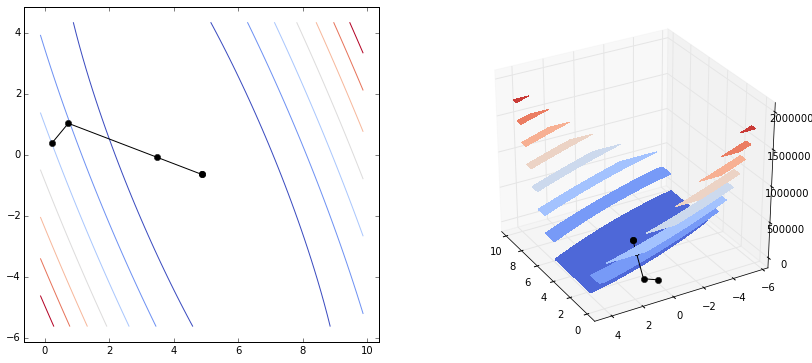

In [13]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121)
ax.contour(theta0, theta1, J_values, cmap=cm.coolwarm)
ax.scatter(optimal_theta[0], optimal_theta[1])
ax.plot(history[:, 0], history[:, 1], 'k-', marker='o')

ax = fig.add_subplot(122, projection='3d')
ax.contourf(theta0, theta1, J_values, cmap=cm.coolwarm)
ax.scatter(optimal_theta[0], optimal_theta[1])
ax.plot(history[:, 0], history[:, 1], 'k-', marker='o')
ax.view_init(30, 150)